# Pipeline for High-z Radio Galaxies 03: AGN/Galaxy regression

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field using regression.  

Sources are all elements detected in the CatWISE2020 catalogue.  Classification will be done  
with the output of the first classification model over the full dataset.  Then, highly confident  
predictions and confirmed sources will be used in a new regression model that will try to  
predict the probability/score of being either a galaxy or an AGN.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

***

## Reading data

In [8]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [75]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

In [10]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [11]:
mqc_version = '7_4d'  # '7_2'

In [12]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [13]:
features_2_discard = ['W1mag', 'W2mag', 'objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [14]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [15]:
# full_catalog_df.describe()

## Random seed

In [16]:
seed = 42

#### Select confirmed galaxies and AGN, and a fraction (or all) unknown sources

In [17]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index

##### Temporary: Select a smaller sample size for testing.

In [18]:
# selected_indices = full_catalog_df.loc[unknown_indices].sample(n=2*len(confirmed_indices), random_state=seed).index
selected_indices = unknown_indices
final_indices    = confirmed_indices.union(selected_indices)

In [19]:
full_catalog_df = full_catalog_df.loc[final_indices]

Create target

$0$ for galaxies and $1$ for AGN

In [20]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

#### Load previous model to create labels for unknown sources.

In [21]:
# if load_model_flag:
AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

Transformation Pipeline and Model Successfully Loaded


In [22]:
AGN_pred_threshold = 0.5
new_labels_train   = pyc.predict_model(AGN_gal_clf,\
                    data=full_catalog_df.loc[selected_indices],\
                    probability_threshold=AGN_pred_threshold, raw_score=True).loc[:, 'Score_1']

In [23]:
full_catalog_df.loc[selected_indices, 'class'] = new_labels_train

In [24]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_unk = len(full_catalog_df) - n_is_AGN - n_is_gal
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies\n' +\
         f'{n_is_unk} have no previous (confirmed) label.')

In this dataset, with 6729647 elements,
30395 of them are marked as AGN, and 55153 are identified as galaxies
6644099 have no previous (confirmed) label.


Remove intermediate targets

In [25]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

---

Histogram of new classes (and their probabilities)

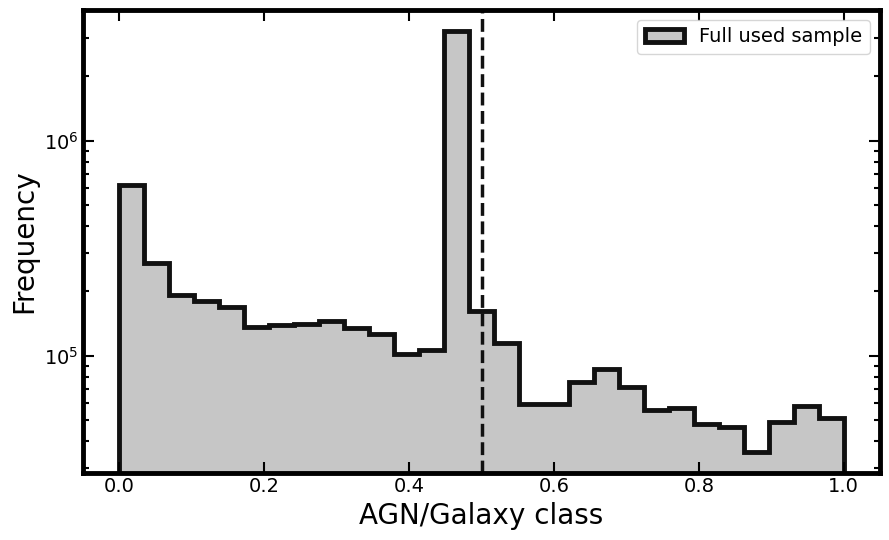

In [26]:
fig             = plt.figure(figsize=(9,5.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'class'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'class'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(full_catalog_df.loc[:, 'class'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Full used sample')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig('plots/classes_AGN_galaxy_plus_predictions.pdf', bbox_inches='tight')
fig.tight_layout()

It is possible to select only sources that are very close to be confirmed.  
Training could be done with these sources only.

In [27]:
gal_threshold = 0.05
AGN_threshold = 0.95

In [28]:
conf_gal = np.sum((full_catalog_df.loc[:, 'class'] == 0.0))

In [29]:
conf_AGN = np.sum((full_catalog_df.loc[:, 'class'] == 1.0))

In [30]:
upgrad_AGN = np.sum((full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00))

In [31]:
upgrad_gal = np.sum((full_catalog_df.loc[:, 'class'] > 0.00) & (full_catalog_df.loc[:, 'class'] < gal_threshold))

In [32]:
print(f'{conf_gal + conf_AGN:,}')

85,548


In [33]:
print(f'{upgrad_gal + upgrad_AGN:,}')

746,816


In [34]:
print(f'{conf_gal + upgrad_gal:,}')

753,430


In [35]:
print(f'{conf_AGN + upgrad_AGN:,}')

78,934


In [36]:
print(f'{conf_gal + conf_AGN + upgrad_gal + upgrad_AGN:,}')

832,364


In [37]:
print(f"{np.sum((full_catalog_df.loc[:, 'class'] > 0.0) & (full_catalog_df.loc[:, 'class'] < 1.0)):,}")

6,644,099


In [38]:
filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] > 0.00) & (full_catalog_df.loc[:, 'class'] < gal_threshold)
filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)

In [39]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)

In [40]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)]

In [41]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

---

Load validation set indices from previous model.

In [42]:
old_validation_idx = pd.Index(np.loadtxt(fname='idx_validation_01.txt', dtype=np.int32))

In [43]:
remaining_idx      = full_catalog_df.drop(index=old_validation_idx).index

In [44]:
needed_val         = np.ceil(len(full_catalog_df) * 0.2).astype(int)

In [45]:
remaining_val_size = needed_val - len(old_validation_idx)

## Split data: Test, Train, Validation

In [46]:
_, temp_val_df = train_test_split(full_catalog_df.drop(index=old_validation_idx), test_size=remaining_val_size,\
                                  random_state=seed, stratify=full_catalog_df.loc[:, 'class'].drop(index=old_validation_idx))
temp_val_idx   = temp_val_df.index
new_val_idx    = old_validation_idx.union(temp_val_idx)

validation_df  = full_catalog_df.loc[new_val_idx]
train_test_df  = full_catalog_df.drop(index=new_val_idx)

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (832364, 39)
Data for Modeling (Train and Test): (665891, 39)
Unseen Data For Validation: (166473, 39)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [47]:
# val_idx = new_val_idx.to_numpy()
# np.savetxt(fname='idx_validation_02.txt', X=val_idx, header='Indices from second AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [48]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [49]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [50]:
rsd_vals

class       319.220053
z_y         210.353902
i_z         137.407929
r_i          86.367772
g_r          81.140181
g_i          48.224504
J_H          37.093825
H_K          26.716362
band_num     25.454297
w2_w3        20.494261
w3_w4         8.775592
rmag          7.749034
gmag          7.378685
r/H           7.257277
g/J           6.806443
imag          6.720031
i/K           6.618947
zmag          6.390488
ymag          6.361995
z/W1          5.765632
y/W2          5.625643
W1mproPM      4.300802
w1/w4         4.241026
w1/w3         4.103259
r/z           3.502492
W2mproPM      3.185976
w2/w4         3.098545
i/y           2.822845
Hmag          1.480697
Jmag          1.423865
W3mag         1.292540
J/K           1.165134
NUVmag        1.032783
FUV/K         0.708892
Kmag          0.606048
W4mag         0.534015
FUVmag        0.375724
FUV_NUV     -17.968829
w1_w2      -135.834939
dtype: float64

In [51]:
correlation = norm_train_test_df.corr()

In [52]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [53]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [54]:
target_feat = 'class'

In [55]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [56]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [57]:
list_drop_corr

['i/K',
 'w1/w4',
 'r/H',
 'g/J',
 'w2/w4',
 'w1/w3',
 'W3mag',
 'FUV_NUV',
 'Jmag',
 'W2mproPM',
 'zmag',
 'Hmag',
 'imag',
 'J/K',
 'gmag',
 'ymag',
 'W1mproPM',
 'y/W2',
 'Kmag',
 'r/z',
 'rmag']

In [58]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [59]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [60]:
corr_discard = norm_train_test_discard.corr()

In [61]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
FUVmag    NUVmag      0.664943
i/y       z_y         0.638186
g_i       g_r         0.613276
          r_i         0.538346
i/y       i_z         0.508971
g_i       class       0.498526
w2_w3     H_K         0.486081
class     w1_w2       0.483297
FUV/K     FUVmag      0.473111
w2_w3     band_num    0.469234
H_K       band_num    0.434705
NUVmag    w3_w4       0.428826
band_num  z/W1        0.420712
W4mag     w3_w4       0.361146
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

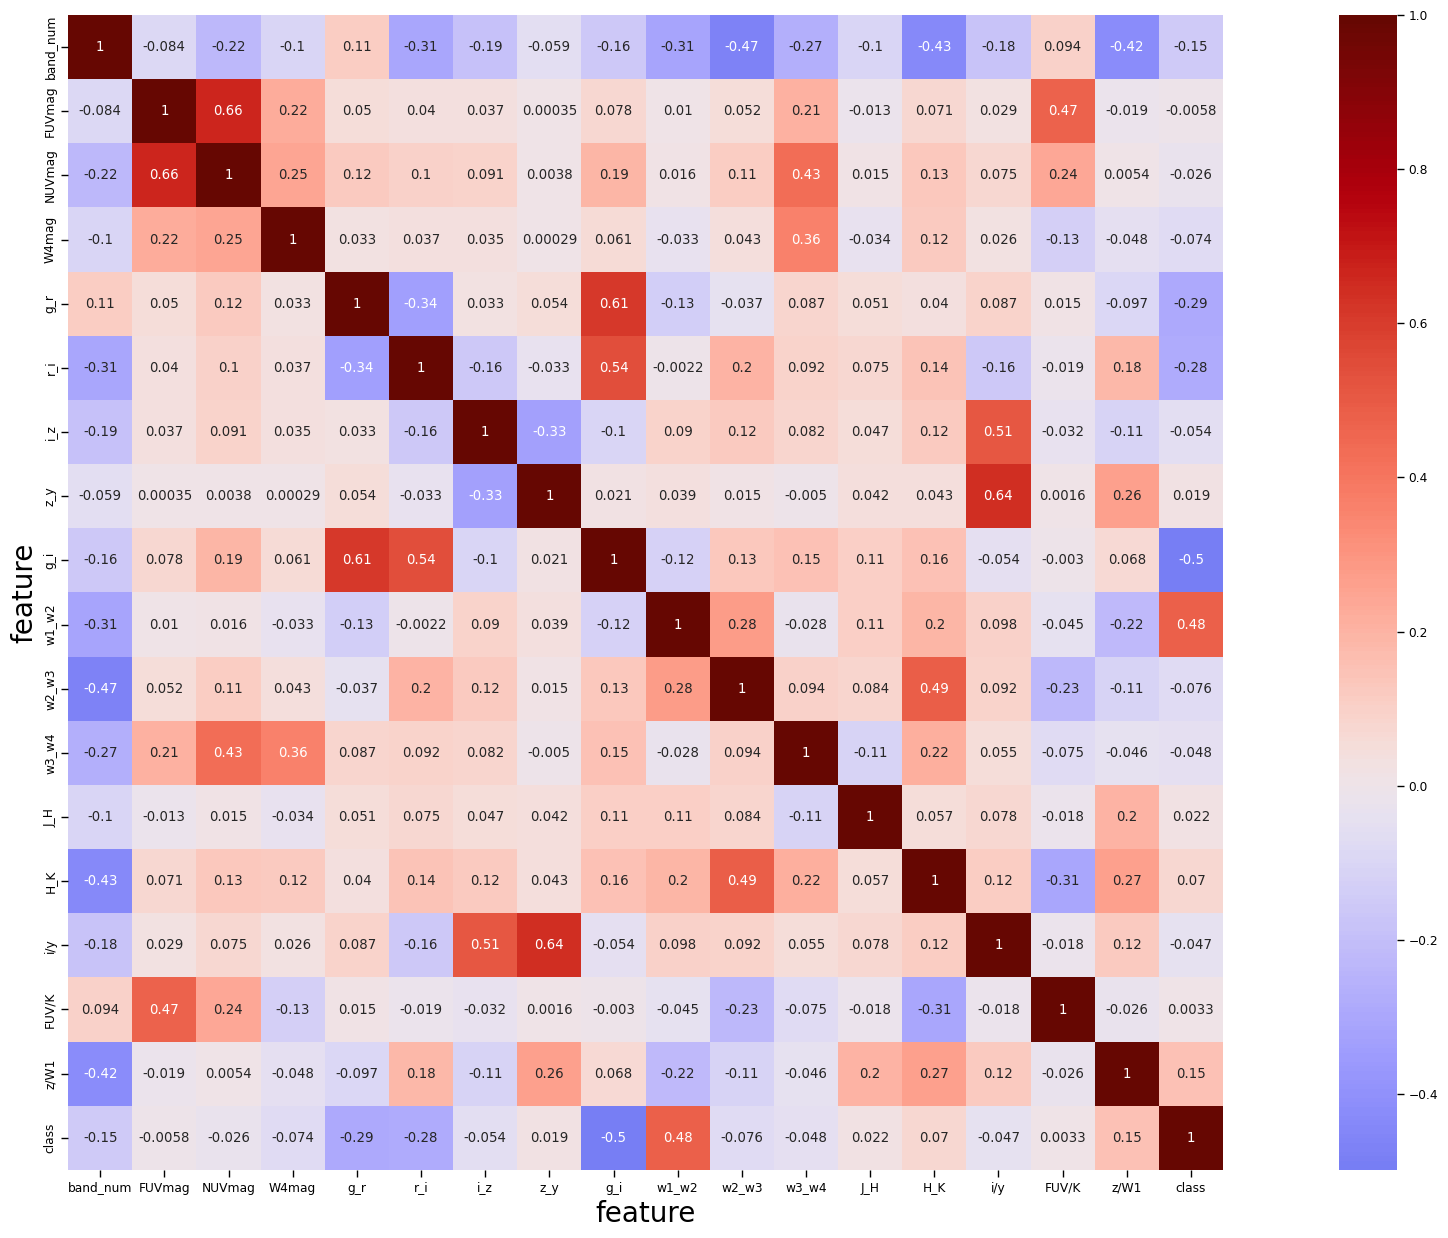

In [62]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [63]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [64]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [65]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUV/K     FUV/K       1.000000
          FUVmag      0.700830
w1_w2     class       0.509389
g_r       g_i         0.364349
band_num  g_r         0.286588
          r_i         0.276833
g_i       class       0.271519
g_r       class       0.257827
r_i       class       0.254876
z_y       i/y         0.246920
r_i       g_i         0.219924
band_num  g_i         0.218143
J_H       H_K         0.213284
band_num  z/W1        0.204182
          i/y         0.199195
r_i       g_r         0.193066
g_r       r_i         0.175867
band_num  z_y         0.170242
i/y       z_y         0.167336
J_H       band_num    0.161380
dtype: float64

In [66]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [67]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [68]:
target_feat = 'class'

In [69]:
list_drop_pps = []

In [70]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [71]:
list_drop_pps

[]

In [72]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [73]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=seed)

In [74]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w1_w2,class,0.509389,classification,True,weighted F1,0.872351,0.937374,DecisionTreeClassifier()
1,g_i,class,0.271519,classification,True,weighted F1,0.872351,0.907010,DecisionTreeClassifier()
2,g_r,class,0.257827,classification,True,weighted F1,0.872351,0.905262,DecisionTreeClassifier()
3,r_i,class,0.254876,classification,True,weighted F1,0.872351,0.904885,DecisionTreeClassifier()
4,i_z,class,0.081399,classification,True,weighted F1,0.872351,0.882741,DecisionTreeClassifier()
5,i/y,class,0.036868,classification,True,weighted F1,0.872351,0.877057,DecisionTreeClassifier()
6,W4mag,class,0.003434,classification,True,weighted F1,0.872351,0.872789,DecisionTreeClassifier()
7,w3_w4,class,0.002905,classification,True,weighted F1,0.872351,0.872721,DecisionTreeClassifier()
8,band_num,class,0.000000,classification,True,weighted F1,0.872351,0.872351,DecisionTreeClassifier()
9,FUVmag,class,0.000000,classification,True,weighted F1,0.872351,0.872351,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [75]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [76]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [77]:
exp_AGN = pyc.setup(data=train_test_df, target='class', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 1 minute with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(665891, 39)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [78]:
pyc.get_config('X').columns

Index(['band_num', 'FUVmag', 'NUVmag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y',
       'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'i/y', 'FUV/K', 'z/W1'],
      dtype='object')

In [79]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [80]:
# used_models_reg      = ['catboost', 'lightgbm', 'xgboost', 'gbr', 'et', 'rf', 'dt', 'ridge', 'lr', 'dummy']  # knn too slow, ridge does not work
final_selection_clf  = ['catboost', 'xgboost', 'rf', 'et', 'gbc', 'dummy']
n_models             = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='MCC')  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, exclude=['knn'], sort='MCC')  # 1 hour, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9959,0.9981,0.9718,0.9818,0.9768,0.9745,0.9746,12.4580
xgboost,Extreme Gradient Boosting,0.9957,0.9981,0.9700,0.9815,0.9757,0.9733,0.9734,12.3140
rf,Random Forest Classifier,0.9957,0.9971,0.9669,0.9842,0.9755,0.9731,0.9731,10.1860
et,Extra Trees Classifier,0.9956,0.9972,0.9671,0.9839,0.9754,0.9730,0.9730,5.2770
gbc,Gradient Boosting Classifier,0.9951,0.9972,0.9665,0.9784,0.9724,0.9697,0.9697,15.9230
dummy,Dummy Classifier,0.9106,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1840


Results from `compare_models` are with ad-hoc imputation are:  

|            |Model                          |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |TT (Sec)|
|------------|-------------------------------|--------|------|------|------|------|------|------|--------|
|**xgboost** |Extreme Gradient Boosting      |0.9979  |0.9876|0.6146|0.8104|0.6989|0.6979|0.7047|92.2400 |

Thus, we select `xgboost` as meta learner.

Thus, we stack the models.

In [81]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9963,0.9988,0.9762,0.9826,0.9794,0.9774,0.9774
1,0.9959,0.9985,0.9719,0.9823,0.9771,0.9748,0.9749
2,0.9960,0.9982,0.9748,0.9804,0.9776,0.9754,0.9754
3,0.9952,0.9981,0.9673,0.9786,0.9730,0.9703,0.9703
4,0.9959,0.9984,0.9729,0.9809,0.9769,0.9746,0.9746
5,0.9952,0.9981,0.9669,0.9793,0.9731,0.9704,0.9705
6,0.9958,0.9983,0.9743,0.9790,0.9767,0.9744,0.9744
7,0.9955,0.9977,0.9700,0.9796,0.9748,0.9723,0.9723
8,0.9956,0.9986,0.9702,0.9799,0.9750,0.9726,0.9726


In [82]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping='asha', optimize='MCC')  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9962,0.9987,0.9760,0.9814,0.9787,0.9766,0.9766
1,0.9956,0.9985,0.9710,0.9801,0.9755,0.9731,0.9731
2,0.9962,0.9982,0.9753,0.9821,0.9787,0.9766,0.9766
3,0.9955,0.9981,0.9678,0.9815,0.9746,0.9721,0.9722
4,0.9959,0.9981,0.9717,0.9818,0.9767,0.9744,0.9745
5,0.9955,0.9981,0.9666,0.9832,0.9748,0.9724,0.9724
6,0.9962,0.9982,0.9755,0.9814,0.9784,0.9763,0.9763
7,0.9955,0.9977,0.9697,0.9796,0.9747,0.9722,0.9722
8,0.9958,0.9986,0.9705,0.9818,0.9761,0.9738,0.9738


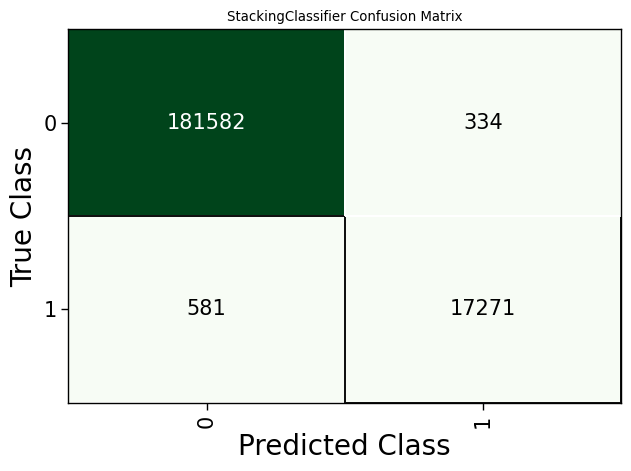

In [83]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

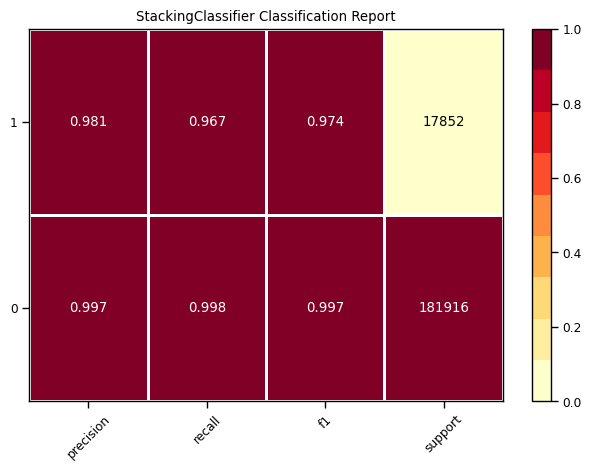

In [84]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

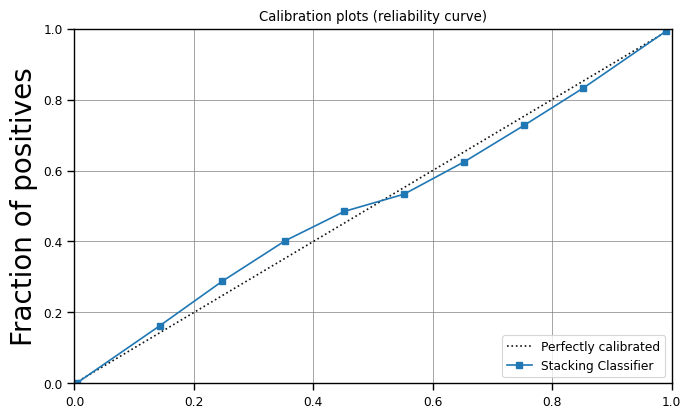

In [85]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

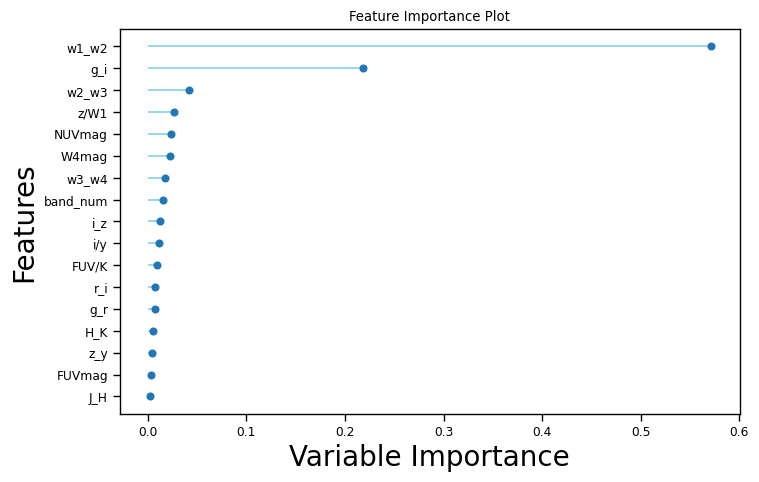

In [86]:
pyc.plot_model(tuned_AGN_clf.estimators_[0], plot='feature_all')

In [87]:
pyc.plot_model(tuned_AGN_clf, plot='parameter')

,Parameters
cv,5
estimators,"[('xgboost', XGBClassifier(base_score=0.5, boo..."
final_estimator,<catboost.core.CatBoostClassifier object at 0x...
n_jobs,12
passthrough,True
stack_method,auto
verbose,0


In [88]:
plt.rcParams.update(plt.rcParamsDefault)

In [89]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9954,0.9979,0.9675,0.9810,0.9742,0.9717,0.9717


,band_num,FUVmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,g_i,w1_w2,...,w3_w4,J_H,H_K,i/y,FUV/K,z/W1,class,Label,Score_0,Score_1
0,1.937074,0.076073,0.194878,0.088527,-0.145342,-0.581490,0.099710,-0.520940,-0.676064,-0.291935,...,0.172677,1.502853,-2.299158,-0.300614,-0.043694,-0.838327,0,0,0.9985,0.0015
1,-0.456340,0.076073,0.194878,0.088527,-1.088656,1.647086,0.311513,-0.066093,0.433627,0.449410,...,0.172677,0.047445,0.267840,0.190764,-0.043694,0.201475,0,0,0.9919,0.0081
2,0.316865,0.076073,0.194878,0.088527,-0.043388,-0.037069,0.186405,0.294596,-0.190233,-1.789888,...,0.172677,0.047445,0.267840,0.464916,-0.043694,0.272486,0,0,0.9987,0.0013
3,-1.571580,0.076073,0.194878,0.088527,-0.751165,-0.759257,-0.445594,-1.037558,-1.262405,1.235626,...,0.172677,0.047445,0.267840,-1.336208,-0.043694,0.496550,1,1,0.0180,0.9820
4,1.937074,0.076073,-5.157052,0.088527,-0.921085,-1.074010,-0.775558,-0.453689,-1.571318,-1.253890,...,0.172677,-2.274290,-0.942588,-1.090803,-0.043694,-2.234908,0,0,0.9988,0.0012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199763,-0.832635,0.076073,0.194878,0.088527,-1.088656,1.346247,-0.154304,-0.868151,0.102997,-0.772001,...,0.172677,0.047445,0.267840,-0.933219,-0.043694,1.060014,0,0,0.9977,0.0023
199764,0.316865,0.076073,0.194878,0.088527,0.122401,-0.743252,0.058133,-0.367275,-0.569352,0.526318,...,-3.927321,0.047445,0.267840,-0.207039,-0.043694,-1.154022,0,0,0.9984,0.0016
199765,-0.073768,0.076073,0.194878,0.088527,1.279611,0.022847,-0.043095,0.331094,1.155726,1.379058,...,0.172677,0.047445,0.267840,0.300048,-0.043694,-0.548398,0,0,0.9987,0.0013
199766,-1.204080,0.076073,0.194878,0.088527,-1.088656,1.308414,-2.218227,1.211867,0.063531,-1.486056,...,0.172677,0.047445,0.267840,-0.882308,-0.043694,2.149406,0,0,0.9973,0.0027


In [90]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9954,0.9979,0.9675,0.9810,0.9742,0.9717,0.9717


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [91]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

In [92]:
if save_model_flag:
    if use_5sigma:
        pyc.save_model(final_AGN_clf, 'models/classification_AGN_galaxy_apr_21_2022')  # Model (it will be saved with .pkl extension)
        # pyc.save_config('../../models/config_classification_AGN_galaxy_apr_21_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [76]:
if load_model_flag:
    if use_5sigma:
        final_AGN_clf = pyc.load_model('models/classification_AGN_galaxy_apr_21_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [77]:
extended_data_AGN = validation_df.loc[:, get_final_column_names(final_AGN_clf, validation_df)].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
extended_cols_AGN = extended_data_AGN.columns.insert(0, 'xgboost')
extended_cols_AGN = extended_cols_AGN.insert(0, 'rf')
extended_cols_AGN = extended_cols_AGN.insert(0, 'et')
extended_cols_AGN = extended_cols_AGN.insert(0, 'gbc')

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [78]:
print('Running data pre-processing:\n')
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_AGN_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [79]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_AGN_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_AGN_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [80]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_AGN_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_AGN_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_AGN_clf.estimators
    estimators_list_ = final_AGN_clf.estimators_

In [81]:
base_models_names = [model[0] for model in estimators_list]

In [82]:
coef_sorted_base_df = {}

In [83]:
for model, model_fit in zip(base_models_names, estimators_list_):
    coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                 'Importance': model_fit.feature_importances_})
    coef_sorted_base_df[model] = (
    coef_base_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN.drop(base_models_names)))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [84]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [85]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for xgboost...
Calculating for rf...
Calculating for et...
Calculating for gbc...


xgboost                   rf                   et                  gbc  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w1_w2  57.167454     w1_w2  43.111829     w1_w2  27.532433     w1_w2   
1        g_i  21.021833       g_i  19.276021       g_i  17.627266       g_i   
2      w2_w3   4.123753       r_i  10.138972       r_i  11.657419     w2_w3   
3      W4mag   2.823857      z/W1   6.065646      z/W1   8.559608      z/W1   
4     NUVmag   2.784636       g_r   5.023158     w2_w3   7.106426       r_i   
5       z/W1   2.487580     w2_w3   3.194681  band_num   7.081232     W4mag   
6      w3_w4   1.748822       i_z   2.945107       g_r   6.693131       g_r   
7   band_num   1.478892       i/y   2.743010       i/y   4.580439    NUVmag   
8        i_z   1.335869  band_num   2.597086       i_z   3.217962     w3_w4   
9        i/y   1.191211       z_y   2.126275       z_y   3.030922       i_z   
10       r_i   0.798528    NUVmag   0.765567     w3_w4   0.771390     FUV/K   
11       g_r   0.690534       H_K   0.534455     W4mag   0.724935       i/y   
12       H_K   0.674535       J_H   0.493499       H_K   0.465179  band_num   
13     FUV/K   0.662624     w3_w4   0.492243    NUVmag   0.458294       H_K   
14       z_y   0.396094     W4mag   0.261697       J_H   0.234433       z_y   
15    FUVmag   0.368602     FUV/K   0.175363     FUV/K   0.182595    FUVmag   
16       J_H   0.245180    FUVmag   0.055392    FUVmag   0.076338       J_H   

               
   Importance  
0   80.625695  
1   16.055473  
2    1.744784  
3    0.394933  
4    0.325497  
5    0.213949  
6    0.137287  
7    0.137219  
8    0.136895  
9    0.100451  
10   0.053797  
11   0.038043  
12   0.026706  
13   0.004944  
14   0.002846  
15   0.001199  
16   0.000283

In [86]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,gbc,44.395547
1,xgboost,18.916189
2,w2_w3,5.847587
3,rf,4.819304
4,et,4.774688
5,w1_w2,4.556349
6,band_num,4.399253
7,z/W1,3.782896
8,i_z,1.713777
9,H_K,1.416039


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	52.109
g_i	18.495
r_i	5.730
z/W1	4.377
w2_w3	4.042
g_r	3.136
band_num	2.796
i/y	2.138
i_z	1.900
z_y	1.389
NUVmag	1.036
W4mag	1.006
w3_w4	0.787
H_K	0.420
FUV/K	0.269
J_H	0.243
FUVmag	0.125


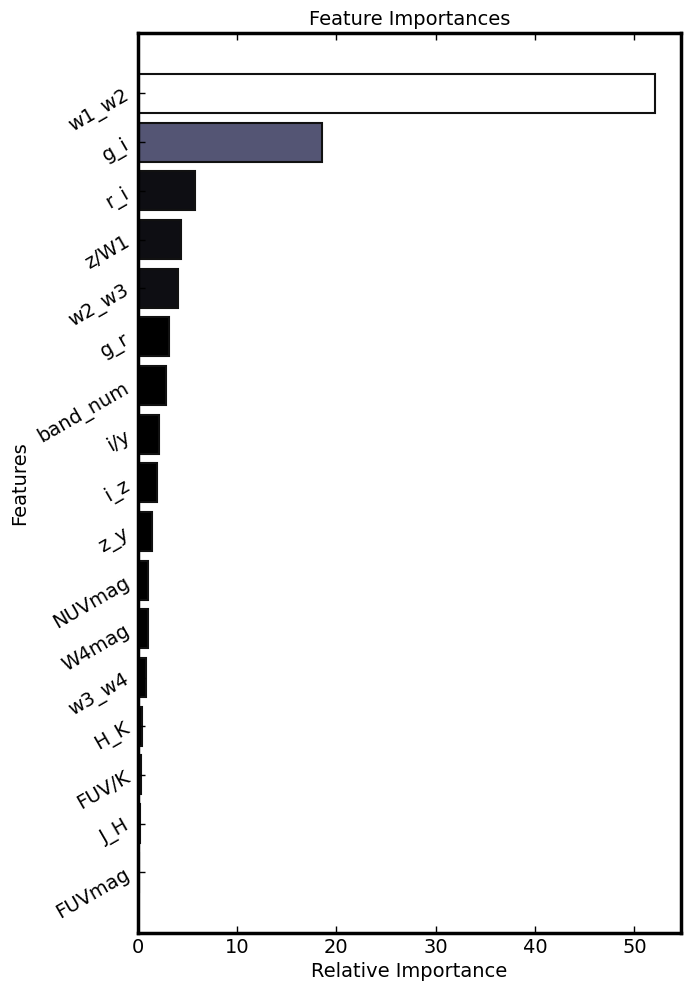

In [87]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_AGN_galaxy_02.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [88]:
AGN_pred_threshold = 0.5
# AGN_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [89]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_pred_threshold, raw_score=True)

Create confusion matrix with validation data.

In [90]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] ==1))]])

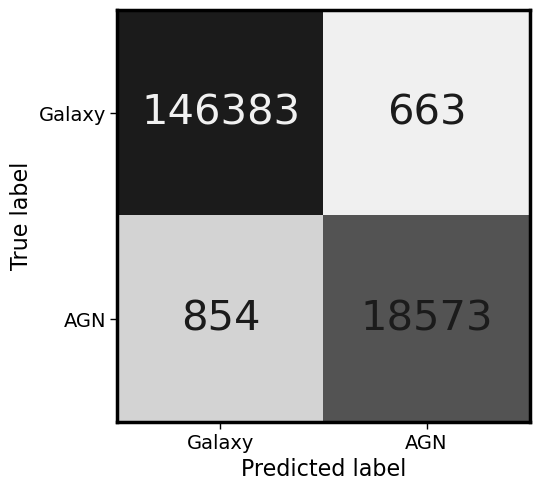

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_val,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_AGN_galaxy_02.pdf', bbox_inches='tight')
plt.show()

In [92]:
TN_AGN, FP_AGN, FN_AGN, TP_AGN = cm_mat_val.flatten().astype('float32')

In [93]:
MCC_AGN_val = ((TP_AGN * TN_AGN) - (FP_AGN * FN_AGN)) /\
            np.sqrt((TP_AGN + FP_AGN) * (TP_AGN + FN_AGN) * (TN_AGN + FP_AGN) * (TN_AGN + FN_AGN))

ACC_AGN_val = (TP_AGN + TN_AGN) / (TP_AGN + TN_AGN + FP_AGN + FN_AGN)

F1_AGN_val  = 2 * TP_AGN / (2 * TP_AGN + FP_AGN + FN_AGN)

Recall_AGN_val = TP_AGN / (TP_AGN + FN_AGN)

In [94]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_val:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_val:.4f}')
print(f'F1-score is F1 = {F1_AGN_val:.4f}')
print(f'Recall is TPR = {Recall_AGN_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.9556
Accuracy is ACC = 0.9909
F1-score is F1 = 0.9608
Recall is TPR = 0.9560


Create confusion matrix for original (v01) validation set.

In [112]:
orig_validation_prediction_clf = validation_prediction_clf.loc[old_validation_idx]

In [113]:
cm_mat_orig_val = np.array([[np.sum(np.array(orig_validation_prediction_clf['class'] == 0) & np.array(orig_validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(orig_validation_prediction_clf['class'] == 0) & np.array(orig_validation_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(orig_validation_prediction_clf['class'] == 1) & np.array(orig_validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(orig_validation_prediction_clf['class'] == 1) & np.array(orig_validation_prediction_clf['Label'] ==1))]])

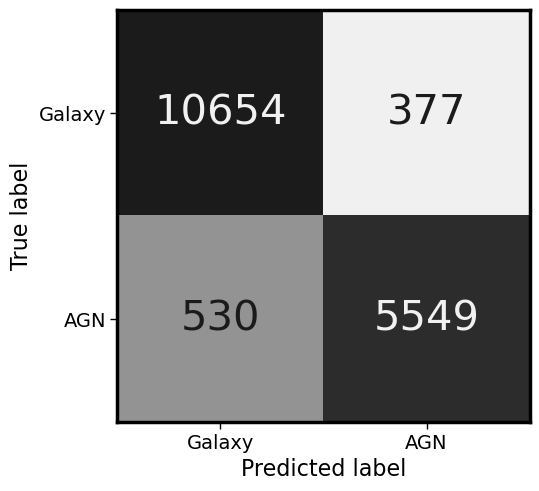

In [118]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_orig_val,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_original_validation_classification_AGN_galaxy_02.pdf', bbox_inches='tight')
plt.show()

In [115]:
TN_AGN_orig_val, FP_AGN_orig_val, FN_AGN_orig_val, TP_AGN_orig_val = cm_mat_orig_val.flatten().astype('float32')

In [116]:
MCC_AGN_orig_val = ((TP_AGN_orig_val * TN_AGN_orig_val) - (FP_AGN_orig_val * FN_AGN_orig_val)) /\
            np.sqrt((TP_AGN_orig_val + FP_AGN_orig_val) * (TP_AGN_orig_val + FN_AGN_orig_val) * (TN_AGN_orig_val + FP_AGN_orig_val) * (TN_AGN_orig_val + FN_AGN_orig_val))

ACC_AGN_orig_val = (TP_AGN_orig_val + TN_AGN_orig_val) / (TP_AGN_orig_val + TN_AGN_orig_val + FP_AGN_orig_val + FN_AGN_orig_val)

F1_AGN_orig_val  = 2 * TP_AGN_orig_val / (2 * TP_AGN_orig_val + FP_AGN_orig_val + FN_AGN_orig_val)

Recall_AGN_orig_val = TP_AGN_orig_val / (TP_AGN_orig_val + FN_AGN_orig_val)

In [117]:
print('Metrics for the original Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_orig_val:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_orig_val:.4f}')
print(f'F1-score is F1 = {F1_AGN_orig_val:.4f}')
print(f'Recall is TPR = {Recall_AGN_orig_val:.4f}')

Metrics for the original Validation set.
Matthews Correlation Coefficient is MCC = 0.8838
Accuracy is ACC = 0.9470
F1-score is F1 = 0.9244
Recall is TPR = 0.9128


In [95]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['class']), train_test_df.loc[:, 'class'], False, 'class'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['class']),
                train_test_df.loc[:, 'class'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [96]:
train_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)

In [97]:
test_prediction_clf = pyc.predict_model(final_AGN_clf, data=test_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)

In [98]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] ==1))]])

In [99]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] ==1))]])

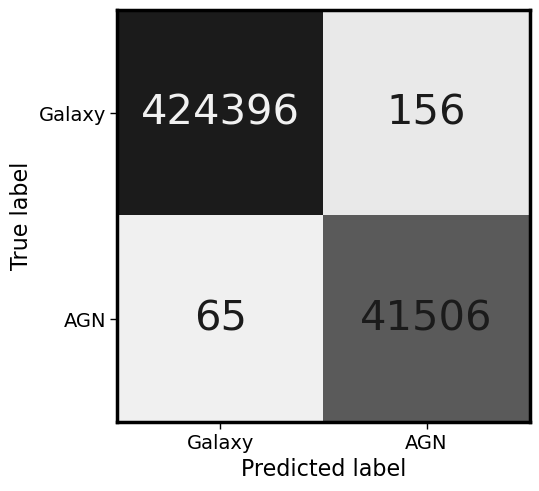

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_train,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_AGN_galaxy_02.pdf', bbox_inches='tight')
plt.show()

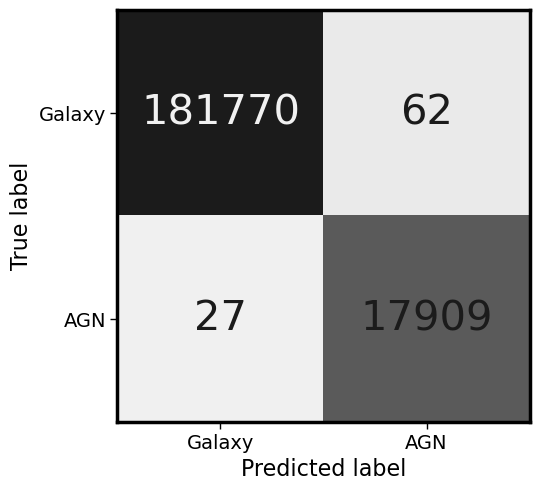

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_test,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_AGN_galaxy_02.pdf', bbox_inches='tight')
plt.show()

In [102]:
TN_AGN_train, FP_AGN_train, FN_AGN_train, TP_AGN_train = cm_mat_train.flatten().astype('float32')

In [103]:
MCC_AGN_train = ((TP_AGN_train * TN_AGN_train) - (FP_AGN_train * FN_AGN_train)) /\
            np.sqrt((TP_AGN_train + FP_AGN_train) * (TP_AGN_train + FN_AGN_train) * 
                    (TN_AGN_train + FP_AGN_train) * (TN_AGN_train + FN_AGN_train))

ACC_AGN_train = (TP_AGN_train + TN_AGN_train) / (TP_AGN_train + TN_AGN_train + FP_AGN_train + FN_AGN_train)

F1_AGN_train  = 2 * TP_AGN_train / (2 * TP_AGN_train + FP_AGN_train + FN_AGN_train)

Recall_AGN_train = TP_AGN_train / (TP_AGN_train + FN_AGN_train)

In [104]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_train:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_train:.4f}')
print(f'F1-score is F1 = {F1_AGN_train:.4f}')
print(f'Recall is TPR = {Recall_AGN_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.9971
Accuracy is ACC = 0.9995
F1-score is F1 = 0.9973
Recall is TPR = 0.9984


In [105]:
TN_AGN_test, FP_AGN_test, FN_AGN_test, TP_AGN_test = cm_mat_test.flatten().astype('float32')

In [106]:
MCC_AGN_test = ((TP_AGN_test * TN_AGN_test) - (FP_AGN_test * FN_AGN_test)) /\
            np.sqrt((TP_AGN_test + FP_AGN_test) * (TP_AGN_test + FN_AGN_test) * 
                    (TN_AGN_test + FP_AGN_test) * (TN_AGN_test + FN_AGN_test))

ACC_AGN_test = (TP_AGN_test + TN_AGN_test) / (TP_AGN_test + TN_AGN_test + FP_AGN_test + FN_AGN_test)

F1_AGN_test  = 2 * TP_AGN_test / (2 * TP_AGN_test + FP_AGN_test + FN_AGN_test)

Recall_AGN_test = TP_AGN_test / (TP_AGN_test + FN_AGN_test)

In [107]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_test:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_test:.4f}')
print(f'F1-score is F1 = {F1_AGN_test:.4f}')
print(f'Recall is TPR = {Recall_AGN_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.9973
Accuracy is ACC = 0.9996
F1-score is F1 = 0.9975
Recall is TPR = 0.9985


Calculate ROC AUC values and plots.

In [108]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

In [109]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 1.00000
Area under the curve (ROC) for test       = 1.00000
Area under the curve (ROC) for validation = 0.99636


In [110]:
fpr_train, tpr_train, thresh_train = roc_curve(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,  tpr_test,  thresh_test  = roc_curve(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_val,   tpr_val,   thresh_val   = roc_curve(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

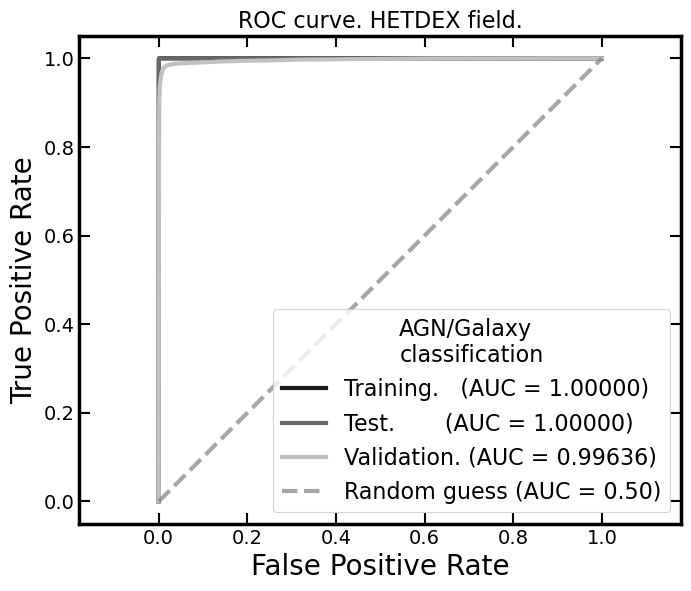

In [111]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
viz_test  = RocCurveDisplay(fpr=fpr_test,  tpr=tpr_test,  roc_auc=roc_auc_test)
viz_val   = RocCurveDisplay(fpr=fpr_val,   tpr=tpr_val,   roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1, lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_val.plot(ax=ax1,   lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='AGN/Galaxy\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_AGN_galaxy_02.pdf', bbox_inches='tight')
plt.show()